### Clasificação de Imagens

O objetivo deste projeto é classificar fotos de algumas flores. Mais especificamente, a partir de um conjunto de dados do Kaggle, temos cinco tipos de flores: Margaridas, Dentes de Leão, Rosas, Girassóis e Tulipas, totalizando 4242 imagens.

Além disso, este projeto pode ser visto também como um tutorial de Transfer Learning, transferência de aprendizado usando uma CNN (Rede neural convolucional). Há um guia passo-a-passo para realizar um classificador CNN usando o Keras com um modelo projetado por mim e outro usando o Transfer Learning.

   *O que é Transfer Learning?*

É a reutilização de um modelo pré-treinado em um novo problema. Isto é, vou usar uma rede neural treinada em outro outro conjunto de dados, geralmente maior, para resolver um novo problema.

   *Por que usar o Transfer Learning?*

- Já que é difícil obter um conjunto de dados grande o suficiente, raramente CNNs são treinadados do zero;

- CNN muito profundas são muito caras para serem treinadas. Os modelos mais complexos podem demorar uma semana utilizando centenas de GPUs muito caras (Tesla V100 e cia);

A maioria dos problemas envolvendo visão computacional usam conjuntos de dados aparentemente grandes (4000 - 20000 imagens), mas que ainda não são grandes o suficiente para se treinar adequadamente uma CNN. Assim, treinar estas redes com centenas de milhões de parametros quase sempre criam o problema do overfitting. Então, usamos o Transfer Learning para nos ajudar.

Para este artigo, todos dados usados estão disponíveis no Kaggle:
https://www.kaggle.com/alxmamaev/flowers-recognition


### Pré-processamento de dados

Como vamos fazer um tutorial prático sobre o Transfer Learning, é necessário um breve tratamento dos dados antes de realizar o treinamento da rede neural. Para tudo ficar bem claro, vou colocar bastante código no artigo e também, todo o código está disponível no GitHub.

**Importando bibliotecas**

In [1]:
import warnings 
warnings.filterwarnings('always') 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Nadam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import random
import tensorflow as tf
import cv2 as cv
import os 
import glob

### Lendo e tratando os dados
Depois de importar tudo que será utilizado, vamos ler as imagens de flores disponíveis. Na pasta “dandelion” (dente de leão), existiam arquivos que não eram imagens, então eu os deletei manualmente.

In [12]:
daisy_dir = glob.glob(os.path.join('flowers/daisy/', '*'))
dandelion_dir = glob.glob(os.path.join('flowers/dandelion/', '*'))
rose_dir = glob.glob(os.path.join('flowers/rose/', '*'))
sunflower_dir = glob.glob(os.path.join('flowers/sunflower/', '*'))
tulip_dir = glob.glob(os.path.join('flowers/tulip/', '*'))
X_path = daisy_dir + dandelion_dir + rose_dir + sunflower_dir + tulip_dir
X = []
for f in X_path:
    X.append(np.array(cv.resize(cv.imread(f), (224,224), interpolation = cv.INTER_AREA))) 
X = np.array(X)
X = X / 255


'X = np.float32(X)\nout = np.zeros(X.shape, np.float32)\nX = cv2.normalize(X, out, 1.0, 0.0, cv2.NORM_MINMAX)'

Cada imagem tem um tamanho diferente, e como sabemos, para entrar numa rede neural todas amostras precisam ter as mesmas dimensões, no caso, escolhi 224x244, isto porque as arquiteturas mais comuns com pesos disponíveis para o Transfer Learning usam estas mesmas dimensões.


Para normalizar os dados, simplesmente efetuamos uma divisão por 255 já que os valores de cada pixel são RGB variando de 0 à 255.

#### Definindo as labels
A entrada de nossa rede neural já está pronta, agora devemos definir os rótulos (labels) para o treinamento

In [13]:
l_daisy = np.zeros(len(daisy_dir), dtype='uint8')
l_dandelion = np.ones(len(dandelion_dir), dtype='uint8')
l_rose = 2*np.ones(len(rose_dir), dtype='uint8')
l_sunflower = 3*np.ones(len(sunflower_dir), dtype='uint8')
l_tulip = 4*np.ones(len(tulip_dir), dtype='uint8')
y = np.concatenate((l_daisy, l_dandelion, l_rose, l_sunflower, l_tulip))
y = to_categorical(y, 5)

# Desta forma, nossas labels estão todas codificadas com o One-Hot-Encoding.

#### Dando uma olhada em nossas imagens
Particularmente, sempre gosto de dar uma olhada no conjunto de dados antes de sair classificando tudo. Então resolvi mostrar algumas imagens do nosso conjunto. Olhando mais detalhadamente todo o conjunto, notei que existem algumas (menos de 10) imagens com labels erradas e que nem flores são. Preferi não deletar estas imagens para manter o experimento com o conjunto original do Kaggle.

### Separando treinamento e validação
Agora vamos separar o nosso conjunto e duas partes. Uma para o treinamento e outra para a validação. Idealmente, deveríamos separar isto em três partes, para avaliarmos o desempenho do classificar em um conjunto nunca visto nem para a validação.

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

In [19]:
# Para evitar problemas de overfitting, usei o ImageDataGenerator.
datagen = ImageDataGenerator(
        zoom_range = 0.1, # Aleatory zoom
        rotation_range= 15, 
        width_shift_range=0.1,  # horizontal shift
        height_shift_range=0.1,  # vertical shift
        horizontal_flip=True,  
        vertical_flip=True)
datagen.fit(X_train)

#### CNN do zero
Agora sim, vamos fazer uma CNN simples.

In [20]:
inp = Input((224,224,3))
conv1 = Conv2D(64, (5,5), padding='valid', activation= 'relu')(inp)
conv1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv1 = BatchNormalization()(conv1)
conv2 = Conv2D(96, (4,4), padding='valid', activation= 'relu')(conv1)
conv2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv2 = BatchNormalization()(conv2)
conv3 = Conv2D(128, (3,3), padding='valid', activation= 'relu')(conv2)
conv3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv3 = BatchNormalization()(conv3)
conv4 = Conv2D(256, (3,3), padding='valid', activation= 'relu')(conv3)
conv4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv4 = BatchNormalization()(conv4)
flat = Flatten()(conv4)
dense1 = Dense(512, activation= 'relu')(flat)
dense1 = Dropout(0.5)(dense1)
dense2 = Dense(64, activation= 'relu')(dense1)
dense2 = Dropout(0.1)(dense2)
out = Dense(5, activation = 'softmax')(dense2)
model = Model(inp, out)
model.compile(optimizer = Nadam(lr = 0.0001) , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [21]:
#E finalmente, treiná-la:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 50, initial_epoch = 0, validation_data = (X_val, y_val))

Epoch 1/50
108/108 [==============================] - 381s 4s/step - loss: 1.7424 - accuracy: 0.4689 - val_loss: 1.9970 - val_accuracy: 0.2639
Epoch 2/50
108/108 [==============================] - 360s 3s/step - loss: 1.1389 - accuracy: 0.6131 - val_loss: 2.6376 - val_accuracy: 0.2639
Epoch 3/50
108/108 [==============================] - 369s 3s/step - loss: 0.8771 - accuracy: 0.6979 - val_loss: 2.5563 - val_accuracy: 0.2674
Epoch 4/50
108/108 [==============================] - 336s 3s/step - loss: 0.6318 - accuracy: 0.7796 - val_loss: 1.9176 - val_accuracy: 0.4074
Epoch 5/50
108/108 [==============================] - 335s 3s/step - loss: 0.4440 - accuracy: 0.8396 - val_loss: 1.0756 - val_accuracy: 0.6100
Epoch 6/50
108/108 [==============================] - 387s 4s/step - loss: 0.3485 - accuracy: 0.8749 - val_loss: 1.0851 - val_accuracy: 0.6620
Epoch 7/50
108/108 [==============================] - 361s 3s/step - loss: 0.2514 - accuracy: 0.9091 - val_loss: 1.1034 - val_accuracy: 0.6632

É fácil ver o problema de overfitting nos gráficos acima. A acurácia de treinamento está próxima de 1 enquanto, no teste próxima de 0.7.

Existem várias formas de reduzir o overfitting, como a regularização BatchNormalization, Dropout e também o aumento do conjunto dados. Vamos nos focar nesta ideia de aumentar o conjunto de dados. Sabendo que não temos mais imagens de flores disponíveis, vamos usar o Transfer Learning como uma forma de reduzir o overfitting.

### Transfer Learning
Vamos utilizar o modelo da VGG-16, com pesos treinados na ImageNet, este conjunto de dados é composto por mais de 14 milhões de imagens classificadas em mais de 20000 classes. Sendo assim, é um conjunto substancialmente maior que nosso conjunto de flores.

In [24]:
import keras
from keras.applications import imagenet_utils
vgg = keras.applications.VGG16(input_shape=(224,224,3), include_top = False, weights= 'imagenet')

58889256/58889256 [==============================] - 2s 0us/step


Desta forma, temos um modelo composto apenas pelas camadas convolucionais pré-treinadas da VGG-16. E agora?

Tendo em mente que os recursos da CNN são mais genéricos (ex. detector de borda) nas camadas iniciais e mais específicos (ex. pétalas) do conjunto de dados originais nas camadas posteriores, aqui estão algumas regras comuns para navegar pelos 4 principais cenários:

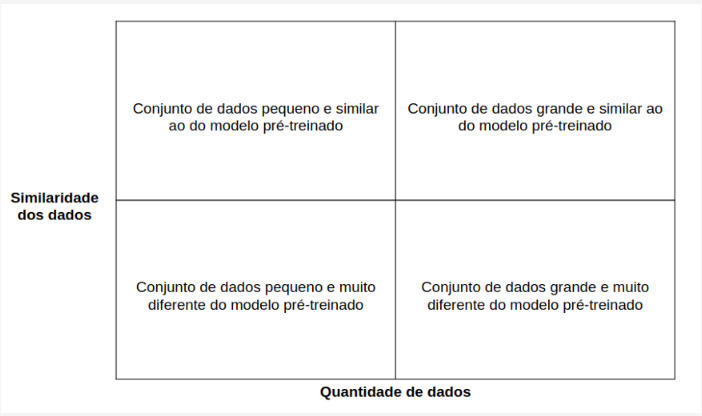

#### Conjunto de dados pequeno e diferente do modelo pré-treinado
- Adiciona-se camadas densamente conectas depois das camadas convolucionais;
- Congelamos os pesos das primeiras camadas convolucionais;
- Treina-se a rede neural.

#### Conjunto de dados grande e diferente do modelo pré-treinado
- Adiciona-se camadas densamente conectas depois das camadas convolucionais;
- Treina-se a rede neural usando os pesos da ImageNet como valores inciais.

#### Conjunto de dados grande e similar ao do modelo pré-treinado
- Adiciona-se camadas densamente conectas depois das camadas convolucionais;
- Pode-se treinar todo o modelo ou congelar os pesos das primeiras camadas convolucionais.

#### Conjunto de dados pequeno e similar ao modelo pré-treinado
- Adiciona-se camadas densamente conectas depois das camadas convolucionais;
- Congelar os pesos das primeiras camadas convolucionais ou todas camadas convolucionais.

Então, em qual dos casos nosso problema de reconhecimento de flores se enquadra? Lembrando que o conjunto de dados possui 4242 amostras de cinco possíveis classes.

Perto do conjunto da ImageNet, nosso conjunto de flores é muito pequeno, então vamos adicionar camadas densamente conectadas e congelar o treinamento de todas as camadas convolucionais.

In [32]:
x = vgg.output
x = Flatten()(x)
x = Dense(3078,activation='relu')(x) 
x = Dropout(0.5)(x)
x = Dense(256,activation='relu')(x) 
x = Dropout(0.2)(x)
out = Dense(5,activation='softmax')(x)
tf_model=Model(inputs=vgg.input,outputs=out)
tf_model.compile(optimizer = Nadam(lr = 0.0001) , loss = 'categorical_crossentropy', metrics=['accuracy'])
for layer in tf_model.layers[:20]:
    layer.trainable=False

### Classificando alguns exemplos
Vamos classificar alguns exemplos de flores para ver onde é que nosso modelo está errando mais.

In [29]:
pred = tf_model.predict(X_val)
pred = np.argmax(pred, axis = 1)

27/27 [==============================] - 101s 4s/step


### Conclusão
O Transfer Learning definitivamente será um dos principais impulsionadores para o Machine Learning e para o sucesso do Deep Learning na adoção mainstream na indústria. Através dele é possível acelerar e melhorar um modelo profundo com facilidade, além de também reduzir os custos computacionais atrelados ao treinamento.

Existem diversas outras arquiteturas pré-treinadas como:
- Xception
- VGG-19
- ResNet, ResNetV2, ResNeXt
- InceptionV3
- MobileNet, MobileNetV2
- DenseNet
- NASNet